# Module 3 Final Project

<strong>Name:</strong> Allie Kelly<br>
<strong>Pace:</strong> Part-time<br>
<strong>Project Review: </strong> September 13, 2019 at 10:30 am EST<br>
<strong>Instructor:</strong> Victor Geislinger<br>
<strong>Blog Post URL:</strong> https://medium.com/@allisonkelly42/hypothesis-testing-with-the-northwind-database-d0382c9328bd

## Import Packages and Data

In [1]:
import sqlite3
import scipy
import scipy.stats as stats
import statsmodels as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import math
import numpy as np
import pandas as pd

In [2]:
#begin SQL cursor, import data
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Hypothesis 1

$H_{0}$ The average product order quantity is equal whether a discount is applied or not.<br>
   
$H_{1}$ The average product order quantity increases when a discount is applied as compared to the average quantity when a discount is not applied. <Br>
    
This is a one-tailed t-test.

In [3]:
#Transform SQL data into DataFrame for the relevant table
cur.execute("""Select * FROM OrderDetail;""")
order_df= pd.DataFrame(cur.fetchall())
order_df.columns = [x[0] for x in cur.description]
order_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


## EDA for Hypothesis 1

In [4]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [5]:
order_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


My immediate impression of the data is that there are 2155 orders that were made and kept in this table. There are 77 different products, and the discounts range from 0% to 25%.  

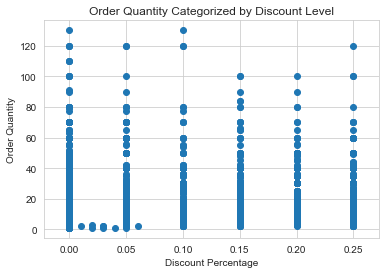

In [6]:
plt.scatter(order_df.Discount, order_df.Quantity)
plt.title("Order Quantity Categorized by Discount Level")
plt.xlabel("Discount Percentage")
plt.ylabel("Order Quantity");

The scatter plot shows that its pretty evenly distributed among each discount level, though there are a few smaller dicounts that only have a few orders. 

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


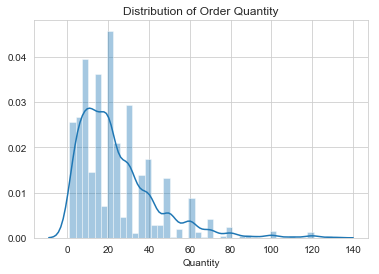

In [7]:
#Checking the distribution of order quantity
sns.distplot(order_df.Quantity)
plt.title("Distribution of Order Quantity");

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


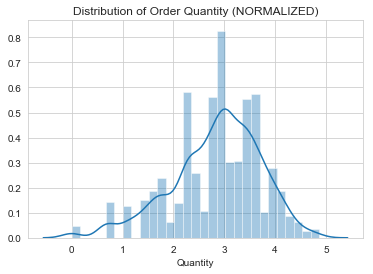

In [8]:
#Fulfilling the assumption that the data follows a normal distribution
sns.distplot(order_df.Quantity.apply(np.log))
plt.title(f"Distribution of Order Quantity (NORMALIZED)");

The distribution of order quantity is relatively normal, though a bit skewed to the right. 

In [9]:
len(order_df.OrderId.unique()) #There are 830 different orders made, multiple products per order

830

In [10]:
order_discount_pivot = pd.pivot_table(order_df, 
                                      index="Discount", 
                                      
                                      columns='ProductId', 
                                      values="Quantity",
                                      fill_value=0.0, 
                                      margins=True)

In [11]:
order_discount_pivot

ProductId,1,2,3,4,5,6,7,8,9,10,...,69,70,71,72,73,74,75,76,77,All
Discount,,,,,,,,,,,,,,,,,,,,,
0.0,17.772727,21.473684,28.800000,17.20,29.333333,26.750000,29.904762,30,4.5,19.454545,...,18.500000,19.043478,21.800000,19.677419,22.125000,22.600000,21.758621,22.730769,17.869565,21.715262
0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000
0.02,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
0.03,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667
0.04,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
0.05,20.000000,16.666667,0.000000,50.00,0.000000,33.000000,13.000000,0,0.0,20.000000,...,31.666667,21.000000,30.000000,20.000000,24.000000,0.000000,70.000000,33.000000,38.200000,28.010811
0.06,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
0.1,10.000000,20.000000,20.000000,22.50,15.000000,0.000000,20.000000,2,20.0,19.000000,...,21.333333,26.750000,24.500000,26.333333,20.000000,0.000000,20.600000,30.000000,24.000000,25.236994
0.15,19.600000,25.000000,0.000000,50.00,0.000000,0.000000,26.500000,15,16.0,49.333333,...,20.000000,29.000000,20.000000,27.500000,25.000000,20.000000,13.000000,27.000000,15.000000,28.382166


This pivot table shows the average order quantity of each product based on discount. From afar, it does look more or less like the quantity increases based on discount level. First however, we'll test whether having a discount affects quantity in general. 

In [12]:
# Splitting DataFrame based on whether or not the order had a discount 
no_discount = order_df.query('Discount == 0.0')
yes_discount = order_df.query('Discount > 0.0')

In [13]:
print(f'Number of orders with a discount: {len(yes_discount)}')
print(f'Average order quantity on orders with discount applied: {round(yes_discount.Quantity.mean(),2)}')

print(f'Number of orders without a discount: {len(no_discount)}')
print(f'Average order quantity on orders without discount applied: {round(no_discount.Quantity.mean(),2)}')


Number of orders with a discount: 838
Average order quantity on orders with discount applied: 27.11
Number of orders without a discount: 1317
Average order quantity on orders without discount applied: 21.72


## One-tailed T-Test

In [14]:
alpha = .05 
results = stats.ttest_ind(yes_discount.Quantity, no_discount.Quantity, equal_var=False)
one_tailed_p = results[1]

In [15]:
if one_tailed_p < alpha:
    print(f'With a p-value of {one_tailed_p}, we can safely reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

With a p-value of 5.65641429030433e-10, we can safely reject the null hypothesis.


In [16]:
#Replace all discounts 6% or below with a 5% discount level because there are so few orders at those levels.
to_replace = [.01, .02, .03, .04, .06]
value = [.05, .05, .05, .05, .05]#if values to replace is a list, value MUST be the same length
order_df.Discount.replace(to_replace=to_replace, value=value, inplace=True)

## Calculate Effect Size of Discount with Cohen's D

Cohen's D will tell us the discount that has the highest effect on order quantity. 

In [17]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [72]:
discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
effect = []
for discount in discounts: 
    experiment = yes_discount.loc[yes_discount['Discount'] == discount].Quantity
    control = no_discount.Quantity
    cd = Cohen_d(experiment, control)
    effect.append(round(cd, 3))
    print(f'The effect size of a {discount * 100} percent discount is {round(cd, 3)}')

The effect size of a 5.0 percent discount is 0.347
The effect size of a 10.0 percent discount is 0.196
The effect size of a 15.0 percent discount is 0.372
The effect size of a 20.0 percent discount is 0.301
The effect size of a 25.0 percent discount is 0.367


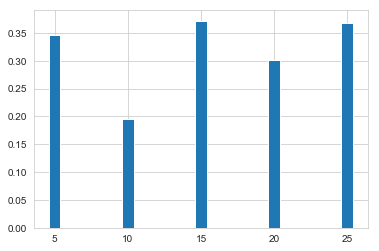

In [77]:
percents = [x*100 for x in discounts]
plt.bar(percents, effect);

The discount with the highest effect size is 15%, followed closely by a 25% discount. 

# Hypothesis 2

$H_{0}$ The day of the week has no effect on order quantity. <br> 
$H_{1}$ The day of the week will cause a difference in order quantity. 
<br><br>
This two-tailed t-test that aims to predict which items are most likely to be ordered (or not ordered) on certain days which would help mitigate any stock issues that could arise from under- or over-ordering. 

In [19]:
cur.execute("""Select od.ProductId, od.Quantity, o.OrderDate
               FROM OrderDetail AS od
               JOIN 'Order' as o
               ON o.Id = od.OrderID;""")
order_df = pd.DataFrame(cur.fetchall()) 
order_df.columns = [i[0] for i in cur.description]
order_df.head()

,ProductId,Quantity,OrderDate
0,11,12,2012-07-04
1,42,10,2012-07-04
2,72,5,2012-07-04
3,14,9,2012-07-05
4,51,40,2012-07-05


In [20]:
#Adding a column that shows what day of the week the order was made
order_df['OrderDate'] = pd.to_datetime(order_df.OrderDate)
order_df['day_of_week'] = order_df['OrderDate'].dt.day_name()

In [21]:
order_df.head()

,ProductId,Quantity,OrderDate,day_of_week
0,11,12,2012-07-04,Wednesday
1,42,10,2012-07-04,Wednesday
2,72,5,2012-07-04,Wednesday
3,14,9,2012-07-05,Thursday
4,51,40,2012-07-05,Thursday


## EDA for Hypothesis 2


In [22]:
# Normalizing Data
order_df.Quantity = order_df.Quantity.apply(np.log)

In [23]:
weekday_quantity_pivot = pd.pivot_table(order_df, 
                                      index="ProductId", 
                                      columns='day_of_week', 
                                      values="Quantity",
                                      fill_value=0.0, 
                                      margins=True)
weekday_quantity_pivot.head()

day_of_week,Monday,Sunday,Thursday,Tuesday,Wednesday,All
ProductId,,,,,,
1,2.858345,2.530896,2.786384,3.188748,2.595236,2.752432
2,2.389001,2.882278,3.183746,3.088090,3.361936,2.927838
3,2.995732,3.176210,3.443776,2.594408,0.000000,3.060314
4,2.652773,2.925201,3.733686,1.445186,3.154876,2.835876
5,2.995732,2.596478,3.180584,3.585060,0.000000,3.126173


This pivot table shows the average order quantity per product per day of the week, with the last column showing average order quantities across all days of the week. The following process will demonstrate which days have significantly higher or lower order quantities as compared to the average order for that product.

In [24]:
#Making a dataframe from the pivot table
weekday_quantity = pd.DataFrame(weekday_quantity_pivot.to_records())
weekday_quantity.drop(77, axis=0, inplace=True)
weekday_quantity.head()

,ProductId,Monday,Sunday,Thursday,Tuesday,Wednesday,All
0,1,2.858345,2.530896,2.786384,3.188748,2.595236,2.752432
1,2,2.389001,2.882278,3.183746,3.088090,3.361936,2.927838
2,3,2.995732,3.176210,3.443776,2.594408,0.000000,3.060314
3,4,2.652773,2.925201,3.733686,1.445186,3.154876,2.835876
4,5,2.995732,2.596478,3.180584,3.585060,0.000000,3.126173


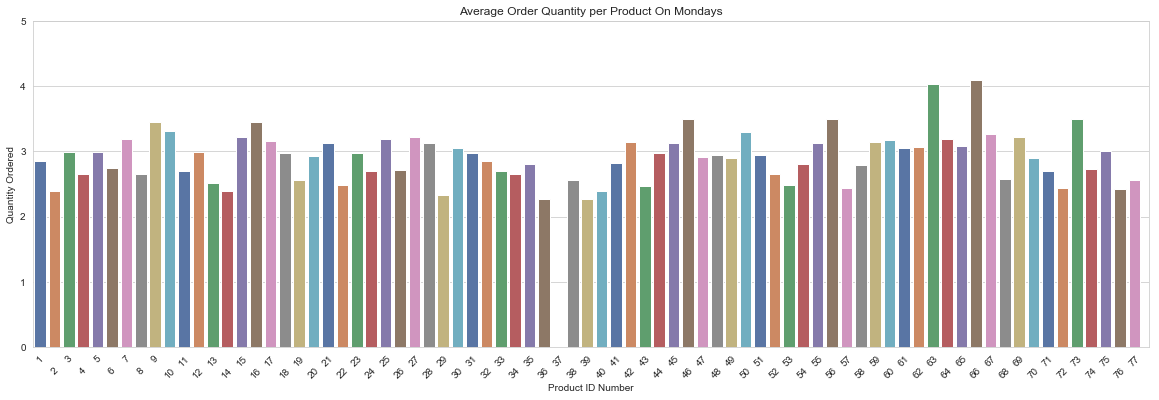

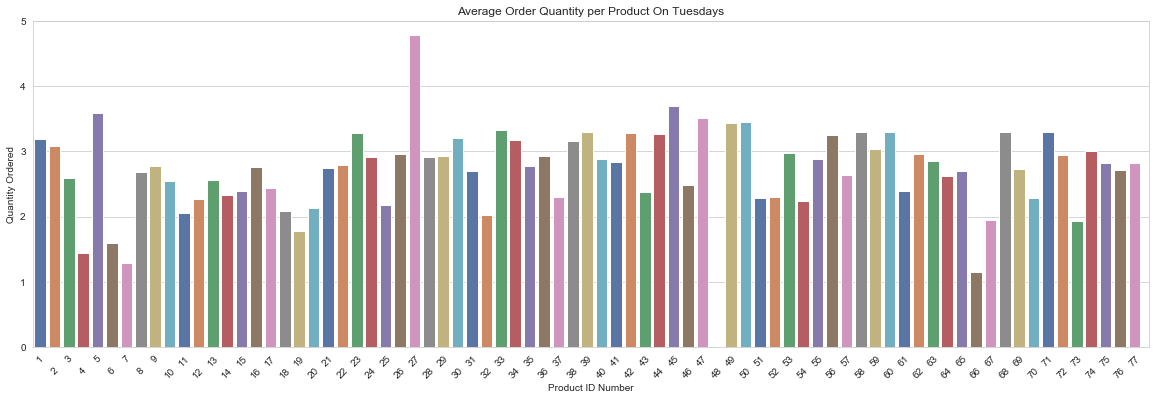

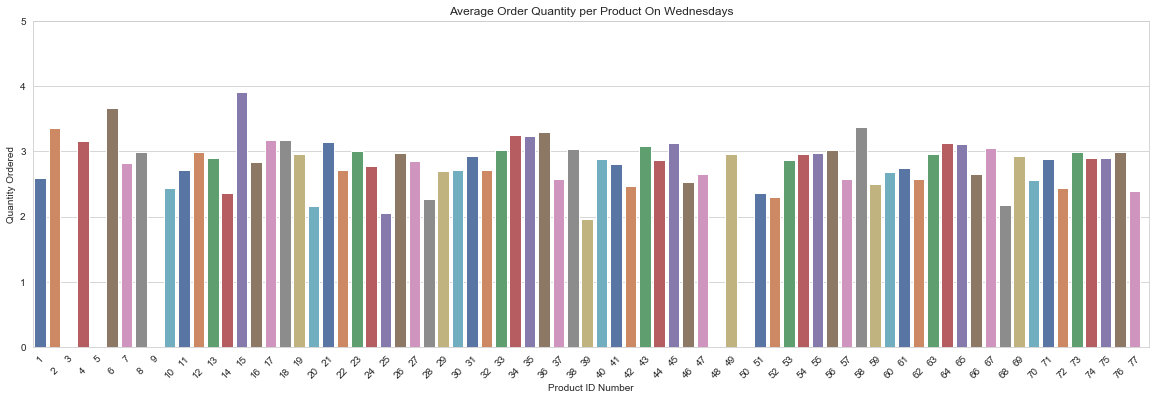

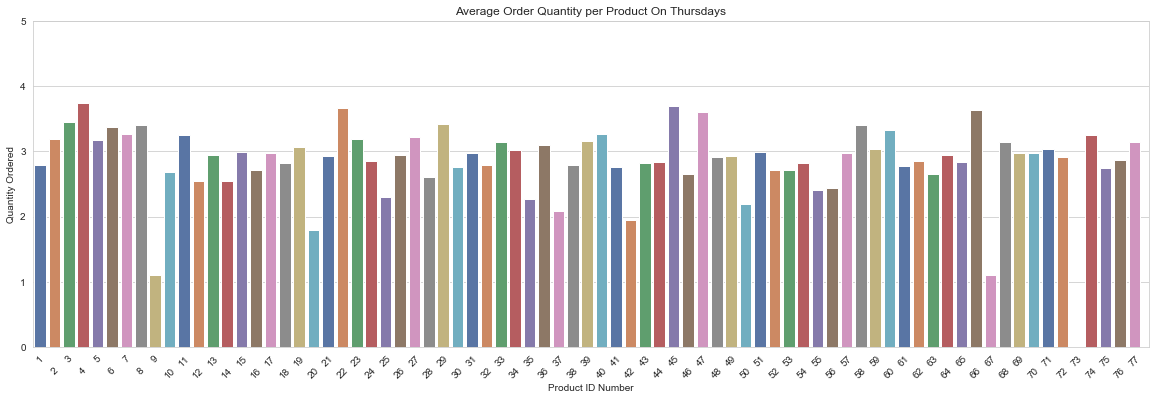

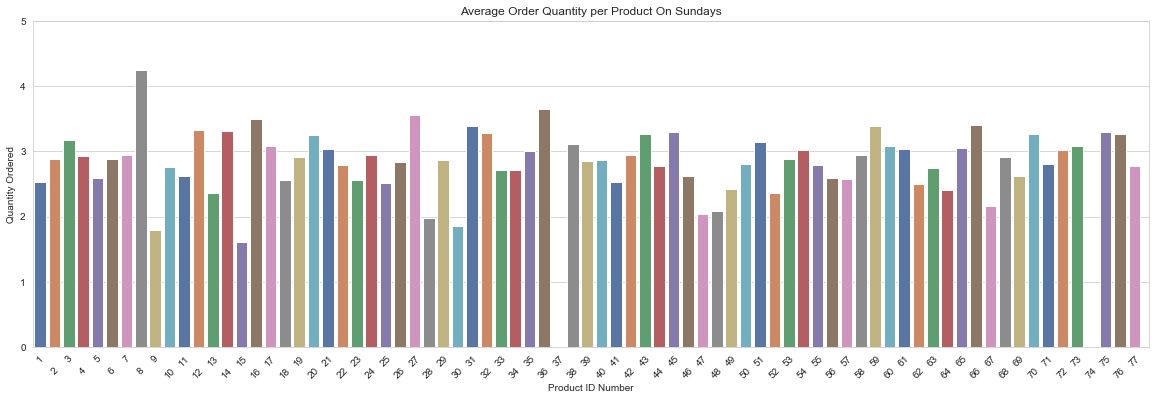

In [25]:
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Sunday"] #No orders on Friday or Saturday
for day in order_days:     
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    sns.barplot(weekday_quantity.ProductId, weekday_quantity[day], palette="deep")
    ax.set_xticks(range(0,78,1))
    ax.set_xticklabels( range(1,78,1), rotation=45)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
    plt.ylim(top=5)    
    plt.xlabel("Product ID Number")
    plt.ylabel("Quantity Ordered")
    plt.title(f"Average Order Quantity per Product On {day}s");

The previous graphs illustrate average order quantity per day per product for each order day. The colors do not represent anything and are used to make it easier to read. From this, we can see that certain products have never been ordered on certain days, and that some days vary drastically. Tuesday generally seems to have lower quantities. 

The following code is written in order to conduct a one sample, two tailed T-test for every product that was ordered for each day of the week, then put it concisely in a dataframe.

## Two-tailed T-Test

In [31]:

pop_means = weekday_quantity.All # Population mean
alpha = .05 # Significance level


p_vals = []
d_o_w = []
product_id = []
difference = []
for day in order_days:
    day_order = order_df.loc[order_df["day_of_week"] == day] #sort by day
    for i in np.arange(1,78): # Sort by product ID
        pop_mean = pop_means[i-1] #Population mean series begins at 0
        a = day_order.loc[day_order["ProductId"]==i].Quantity
        
        T, two_tailed_p = stats.ttest_1samp(a=a, popmean=pop_mean)
        if alpha > two_tailed_p/2:
            difference.append(np.exp(a).mean()-np.exp(pop_mean))
            p_vals.append(round(two_tailed_p,2))
            d_o_w.append(day)
            product_id.append(i)
        else:
            continue
            
results_df = pd.DataFrame([p_vals, d_o_w, product_id, difference]).transpose()
results_df.columns = ['PVal', "Day", "ProductID", "Difference"]

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


In [66]:
cur.execute("""Select p.Id, p.ProductName
               FROM Product AS p;""")
product_df = pd.DataFrame(cur.fetchall()) 
product_df.columns = ["ProductID", "ProductName"]
print(product_df.info())
product_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
ProductID      77 non-null int64
ProductName    77 non-null object
dtypes: int64(1), object(1)
memory usage: 1.3+ KB
None


,ProductID,ProductName
0,1,Chai
1,2,Chang
2,3,Aniseed Syrup
3,4,Chef Anton's Cajun Seasoning
4,5,Chef Anton's Gumbo Mix


In [69]:
results_df.ProductID = results_df.ProductID.astype(int)
results_df = pd.merge(results_df, product_df, on='ProductID', how='inner')

In [71]:
results_df.sort_values(by="Day")

,PVal,Day,ProductID,Difference,ProductName
0,0,Monday,2,-6.68718,Chang
1,0.07,Monday,10,18.6286,Ikura
2,0.02,Monday,16,13.0167,Pavlova
4,0.09,Monday,25,15.5324,NuNuCa Nuß-Nougat-Creme
6,0.06,Monday,28,11.1188,Rössle Sauerkraut
7,0.03,Monday,36,-9.83162,Inlagd Sill
9,0.02,Monday,56,17.5383,Gnocchi di nonna Alice
10,0.03,Monday,67,13.021,Laughing Lumberjack Lager
28,0.1,Sunday,20,14.4369,Sir Rodney's Marmalade
27,0.04,Sunday,14,15.4982,Tofu


Results: The above dataframe illustrates which products on which days historically have significantly lower or higher order counts, which can help stockists increase or decrease how much of those products are in stock so the company does not have a surplus of perishable food, nor under-stocks which can cause clients to switch to a competitor. 

Positive values in the difference column indicate larger orders on those days, so stock should increase. Negative values indicate smaller orders for those products. 

The null hypothesis was not rejected for most products on most days, however once the data becomes more robust, more analysis can be done. From here, we should check for increases of certain products around holidays, seasons, etc. and consistently run weekly analyses to best continue to suit our customers' needs.

# Hypothesis 3

$H_{0}$ Order total does not change based on country where order is placed. 
<br> 
$H_{1}$ Order country has an effect on order total.  

This is a two-tailed t-test.

In [35]:
cur.execute("""Select od.ProductId, od.OrderID, od.Quantity, od.Discount, od.UnitPrice, o.ShipCountry
               FROM OrderDetail AS od
               JOIN 'Order' as o
               ON o.Id = od.OrderID;""")
country_df= pd.DataFrame(cur.fetchall())
country_df.columns = [x[0] for x in cur.description]
country_df.head()

,ProductId,OrderId,Quantity,Discount,UnitPrice,ShipCountry
0,11,10248,12,0.0,14.0,France
1,42,10248,10,0.0,9.8,France
2,72,10248,5,0.0,34.8,France
3,14,10249,9,0.0,18.6,Germany
4,51,10249,40,0.0,42.4,Germany


## EDA for Hypothesis 3

In [36]:
# Calculate unit price with discount
# Multiply new unit price with Quantity
# Add all quantity totals for all items with same Order ID

country_df['ItemTotal_WithDiscount'] = round((1-country_df['Discount']) * country_df['UnitPrice'],2) * country_df['Quantity']

In [37]:
order_total_df = country_df.loc[:,['OrderId','ShipCountry','ItemTotal_WithDiscount']]

In [38]:
total_by_country = order_total_df.groupby(['OrderId', 'ShipCountry']).sum()

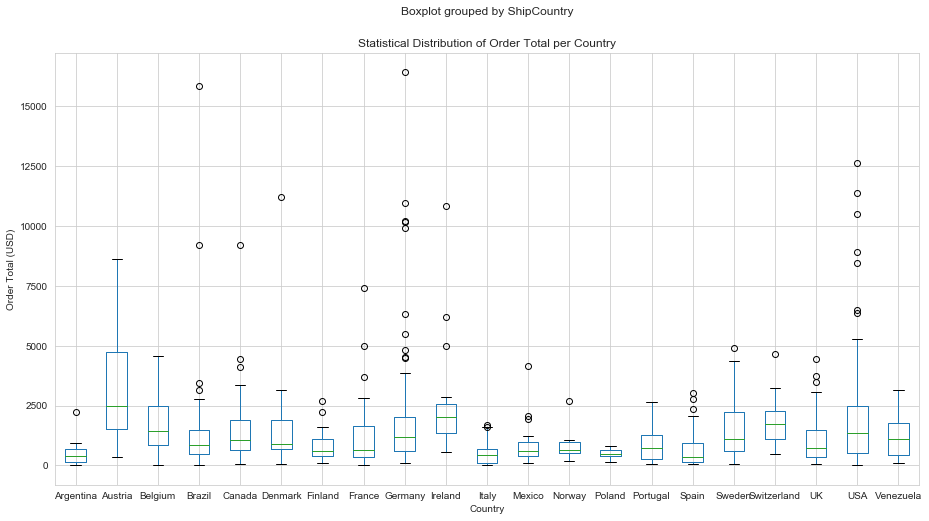

In [39]:
total_by_country.boxplot('ItemTotal_WithDiscount', by='ShipCountry', figsize=(15, 8))
plt.title("Statistical Distribution of Order Total per Country")
plt.xlabel("Country")
plt.ylabel("Order Total (USD)");

This box plot seems to show that there are a few countries with massive outliters that reach far and away from the average order from their respective country. It seems as if the highest range is around 2500 or less for most countries, while the highest single order reaches to neary 17,500.

In [40]:
total_by_country = total_by_country.reset_index()
q = total_by_country.ItemTotal_WithDiscount.quantile(0.99)
total_by_country = total_by_country[total_by_country["ItemTotal_WithDiscount"] < q] 
#Resetting index and removing rows with totals more than 3 standard deviations from the mean

The distribution is heavily positively skewed, so it would be in our best interest to normalize, as seen below.

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


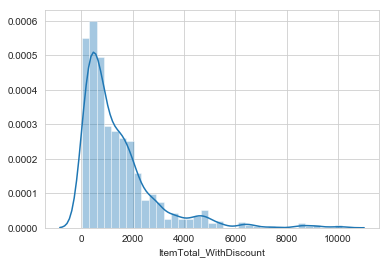

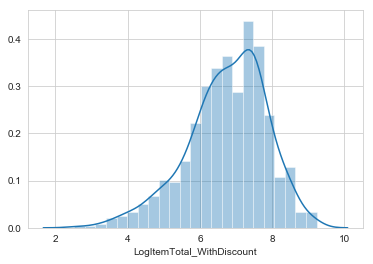

In [41]:
plt.figure()

sns.distplot(total_by_country.ItemTotal_WithDiscount)

total_by_country['LogItemTotal_WithDiscount'] = total_by_country.ItemTotal_WithDiscount.apply(np.log)
plt.figure()
sns.distplot(total_by_country.LogItemTotal_WithDiscount);

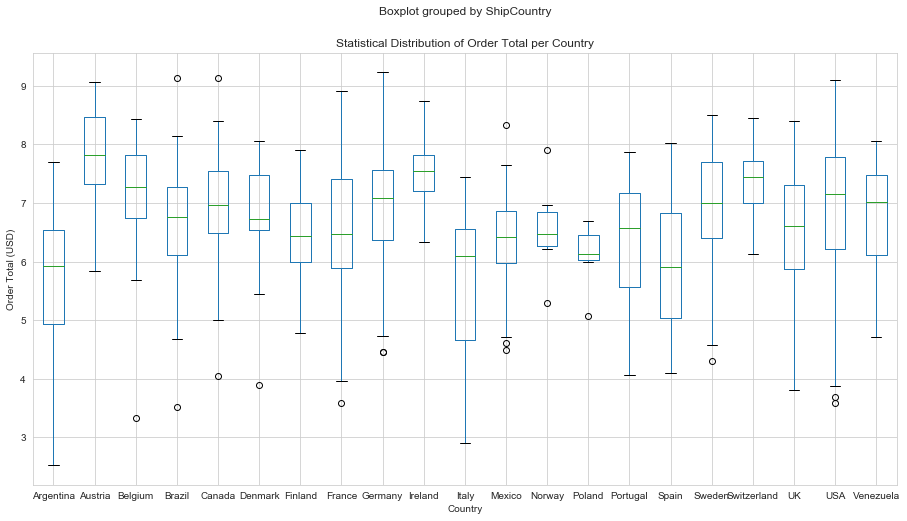

In [42]:
total_by_country.boxplot('LogItemTotal_WithDiscount', by='ShipCountry', figsize=(15, 8))
plt.title("Statistical Distribution of Order Total per Country")
plt.xlabel("Country")
plt.ylabel("Order Total (USD)");

In [43]:
countries =  list(total_by_country.ShipCountry.unique())
pop_mean = total_by_country.LogItemTotal_WithDiscount.mean()
avg_order = []
countries_to_look_at = []

for country in countries:
    a = total_by_country.loc[total_by_country["ShipCountry"]==country].LogItemTotal_WithDiscount
    T, two_tailed_p = stats.ttest_1samp(a=a, popmean=pop_mean)
    
    if alpha>two_tailed_p/2:
        countries_to_look_at.append(country)
        avg_order.append(round(np.exp(a).mean()-np.exp(pop_mean), 2))

In [44]:
df = pd.DataFrame([countries_to_look_at, avg_order]).transpose()
df.columns = ["Country", "Avg_Order_Diff"]

In [45]:
sorted_df = df.sort_values(by="Avg_Order_Diff", ascending=False)
sorted_df

,Country,Avg_Order_Diff
3,Austria,2348.42
9,Ireland,1322.99
5,USA,922.24
2,Switzerland,909.03
1,Germany,768.09
0,France,204.94
8,UK,201.4
4,Mexico,-9.44
7,Spain,-69.78
6,Italy,-288.44


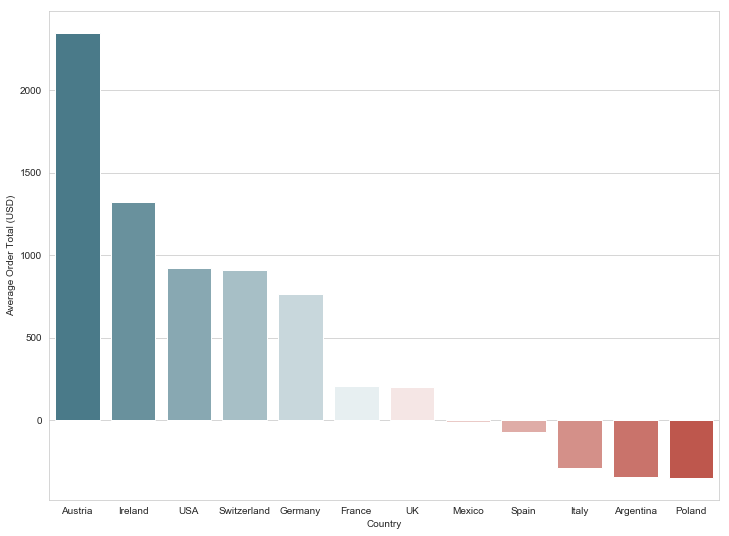

In [46]:
plt.figure(figsize = (12,9))
pal = sns.diverging_palette(220, 15, n= 12, sep=10)
sns.barplot(sorted_df.Country, sorted_df.Avg_Order_Diff, palette = pal)
plt.ylabel("Average Order Total (USD)");

From here, focus should be on properly staffing larger accounts and maintaining a positive relationship with accounts above 0. For those below, further analysis can be done to identify why orders from those countries are lower than average. Shipping times, expired products, damaged orders, etc. should be investigated, as well as identifying if there is a problem with the sales managers that oversee these accounts. 

# Hypothesis 4

$H_{0}$ Supervisor has no affect on the performance of their subordinates, as determined by order totals.  
<br> 
$H_{1}$ A group's supervisor has a significant effect (positive or negative) on performance of said group of employees as determined by order totals. .  

This is a two-tailed t-test.

In [47]:
cur.execute("""Select e.Id, e.ReportsTo, od.ProductId, od.OrderId, od.Quantity, od.Discount, od.UnitPrice
               FROM Employee AS e
               LEFT JOIN 'Order' AS o
               ON e.Id = o.EmployeeId
               LEFT JOIN OrderDetail AS od
               ON o.Id = od.OrderId;""")
employee_groups_df = pd.DataFrame(cur.fetchall()) 
employee_groups_df.columns = [i[0] for i in cur.description]
employee_groups_df.head()

,Id,ReportsTo,ProductId,OrderId,Quantity,Discount,UnitPrice
0,1,2.0,2,10258,50,0.2,15.2
1,1,2.0,5,10258,65,0.2,17.0
2,1,2.0,32,10258,6,0.2,25.6
3,1,2.0,36,10270,30,0.0,15.2
4,1,2.0,43,10270,25,0.0,36.8


In [48]:
employee_groups_df['OrderTotal'] = round((1-employee_groups_df['Discount']) * employee_groups_df['UnitPrice'],2) * employee_groups_df['Quantity']

In [49]:
employee_groups_df.drop(['ProductId', "Discount", "UnitPrice", "Quantity"], axis=1, inplace=True)

In [50]:
employee_groups_df.isna().any()

Id            False
ReportsTo      True
OrderId       False
OrderTotal    False
dtype: bool

In [51]:
employee_groups_df.fillna(0, inplace=True)
employee_groups_df.isna().any()

Id            False
ReportsTo     False
OrderId       False
OrderTotal    False
dtype: bool

In [78]:
employee_groups_df.ReportsTo = [int(x) for x in employee_groups_df.ReportsTo] 
employee_groups_df.info()#TURN REPORTS TO COLUMN INTO INTEGER THROUGH LIST COMPREHENSION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
Id            2155 non-null int64
ReportsTo     2155 non-null int64
OrderId       2155 non-null int64
OrderTotal    2155 non-null float64
dtypes: float64(1), int64(3)
memory usage: 67.4 KB


In [79]:
manager_2_df = employee_groups_df.query("ReportsTo == 2")
manager_5_df = employee_groups_df.query("ReportsTo == 5")

In [80]:
results = stats.ttest_ind(manager_2_df.OrderTotal, manager_5_df.OrderTotal, equal_var=False)
one_tailed_p = results[1]
if one_tailed_p < alpha:
    print(f'With a p-value of {one_tailed_p}, we can safely reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

We cannot reject the null hypothesis.
